# Previsão de Casos de Dengue no Brasil com Aprendizado de Máquina

**Grupo:** Renan Teixeira e Rodrigo Rodrigues

Este notebook tem como objetivo aplicar técnicas de **regressão** para prever o número de casos de **dengue** em municípios brasileiros, utilizando variáveis climáticas, demográficas e regionais. O estudo tem como base dados públicos disponíveis no [Kaggle](https://www.kaggle.com/datasets/jimmyyyyyyy/dengue-in-brazil-2012-2021), referentes ao período de 2012 a 2021.

## 🎯 Problema a ser resolvido

Dado um conjunto de informações sobre temperatura, precipitação, densidade populacional, área, entre outros fatores, queremos estimar a quantidade de casos de dengue que ocorrerão em determinada localidade e ano. Essa previsão pode ajudar autoridades de saúde pública na **tomada de decisões preventivas** e no **controle de surtos**.

## 📊 Sobre o dataset

Cada instância (linha) do dataset representa o **registro anual de um município brasileiro**, com as seguintes variáveis:

| Atributo            | Tipo       | Descrição |
|---------------------|------------|-----------|
| `year`              | Numérico   | Ano do registro |
| `state`             | Categórico | Sigla do estado |
| `region`            | Categórico | Região do país (N, NE, SE, S, CO) |
| `city`              | Categórico | Nome do município |
| `population`        | Numérico   | População estimada |
| `density`           | Numérico   | Densidade demográfica (hab/km²) |
| `state_area`        | Numérico   | Área do estado em km² |
| `temperature`       | Numérico   | Temperatura média anual |
| `temp_variation`    | Numérico   | Variação média da temperatura |
| `precipitation`     | Numérico   | Precipitação média anual (chuvas) |
| `dengue_cases`      | Numérico   | Número de casos de dengue no ano |

A variável-alvo que será prevista pelos modelos é **`dengue_cases`**.

---

Na próxima seção, será realizada a **análise exploratória de dados (EDA)** para entender o comportamento das variáveis e detectar possíveis padrões, correlações e ruídos.


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

sns.set_theme(style="darkgrid")

# Leitura do CSV
df = pd.read_csv('dengue.csv')

# Padronizar nomes das colunas
df.columns = df.columns.str.strip().str.lower()

# Renomear colunas para clareza e consistência
df.rename(columns={
    'mean_tmp': 'temperature',
    'change_tmp': 'temp_variation',
    'percipitation': 'precipitation',
    'state_area(km2)': 'state_area',
    'cases': 'dengue_cases'
}, inplace=True)

# Criar variável de densidade demográfica
df['density'] = df['population'] / df['state_area']

# Verificar estrutura e resumo dos dados
print("Colunas do dataset:", df.columns.tolist())
print("\nDimensão do dataset:", df.shape)
print("\nInformações dos dados:")
print(df.info())
print("\nResumo estatístico:")
print(df.describe())


Colunas do dataset: ['year', 'state', 'temperature', 'min_tmp', 'max_tmp', 'precipitation', 'temp_variation', 'state_id', 'dengue_cases', 'region', 'state_area', 'population', 'density']

Dimensão do dataset: (258, 13)

Informações dos dados:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258 entries, 0 to 257
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            258 non-null    int64  
 1   state           258 non-null    object 
 2   temperature     258 non-null    float64
 3   min_tmp         258 non-null    float64
 4   max_tmp         258 non-null    float64
 5   precipitation   258 non-null    float64
 6   temp_variation  258 non-null    float64
 7   state_id        258 non-null    float64
 8   dengue_cases    258 non-null    int64  
 9   region          258 non-null    object 
 10  state_area      258 non-null    float64
 11  population      258 non-null    int64  
 12  density         2

## Análise Exploratória de Dados (EDA)

O objetivo desta etapa é entender o comportamento das variáveis, identificar padrões, possíveis correlações e problemas que precisam ser tratados antes da modelagem.

### Variável alvo: `dengue_cases`

A variável `dengue_cases` representa o número de casos de dengue por município e ano. A análise da distribuição mostra forte assimetria à direita, com valores extremos indicando surtos epidêmicos. O boxplot confirma a presença de outliers, que serão considerados na etapa de limpeza.

### Variáveis preditoras

As variáveis numéricas `temperature`, `temp_variation`, `precipitation`, `population`, `density` e `state_area` foram analisadas individualmente. A maioria apresenta distribuição assimétrica, especialmente `population` e `state_area`, o que justifica a necessidade de normalização.

### Correlação entre variáveis

A matriz de correlação mostra que `dengue_cases` possui relação positiva com `population`, `temperature` e `temp_variation`. As demais variáveis apresentam correlação baixa ou nula. Não há indícios fortes de multicolinearidade entre os atributos.

### Conclusões

- A presença de outliers em `dengue_cases` deve ser tratada com cautela.
- A normalização será necessária para variáveis com escalas muito diferentes.
- As variáveis categóricas como `state` e `region` poderão ser codificadas, caso sejam incluídas na modelagem.
- As variáveis com maior correlação com `dengue_cases` servirão de base para a seleção de atributos.


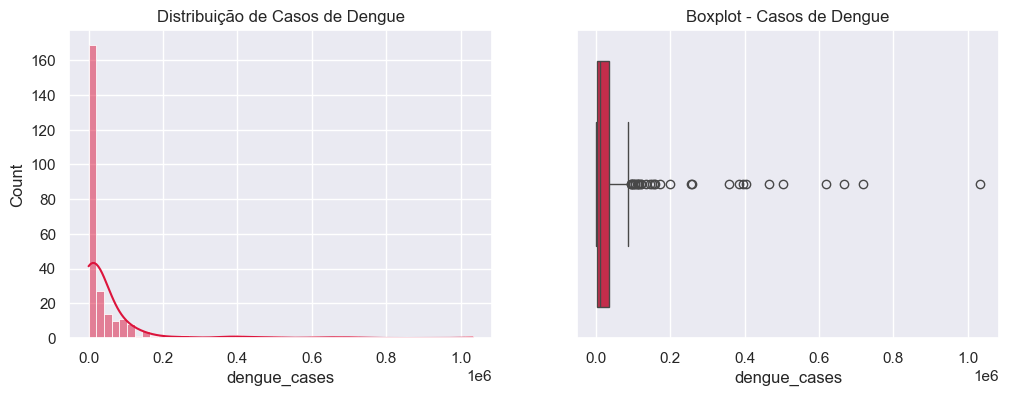

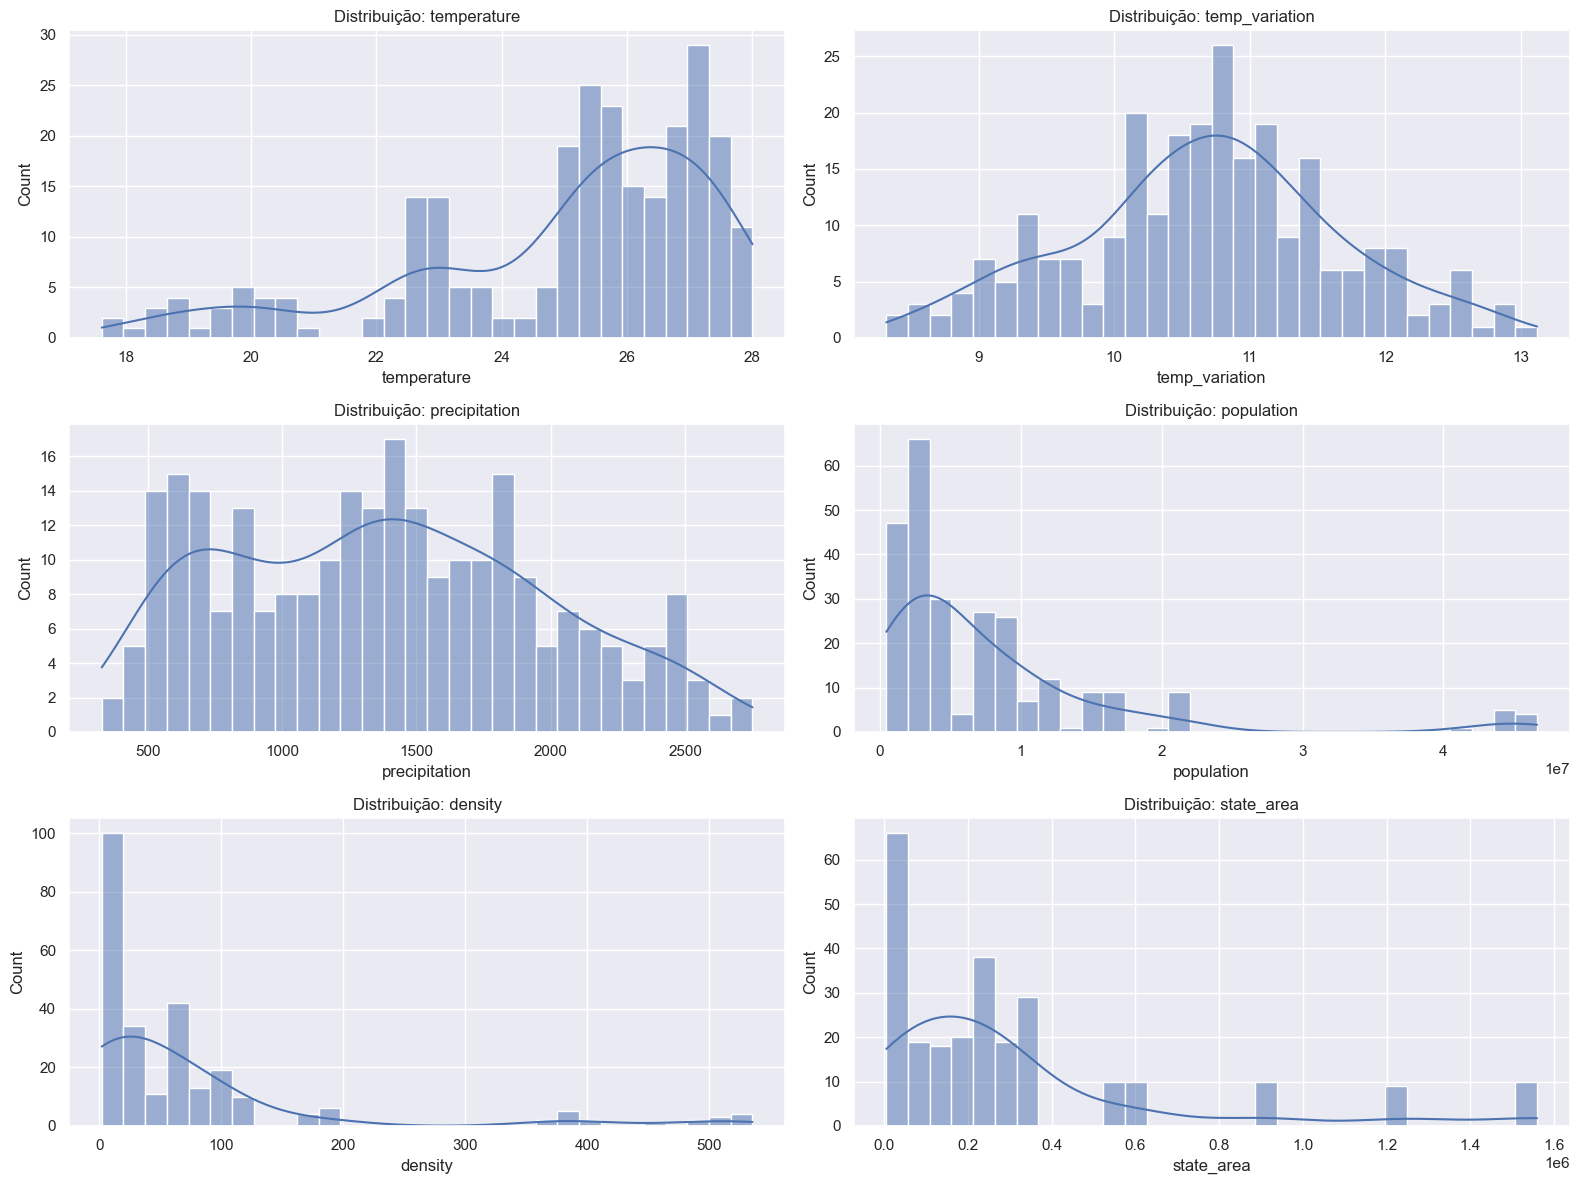

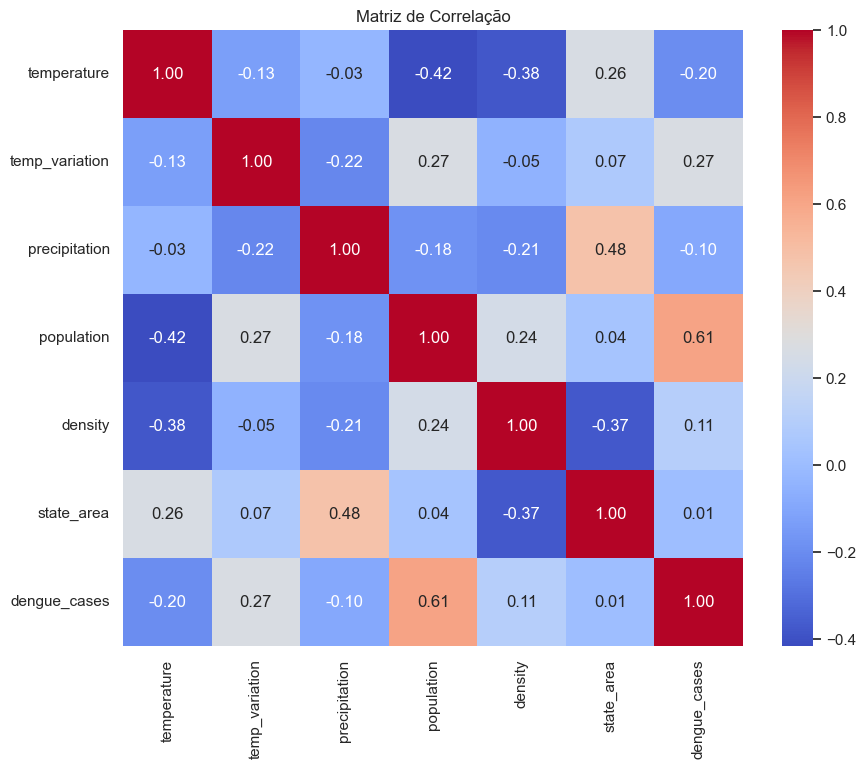

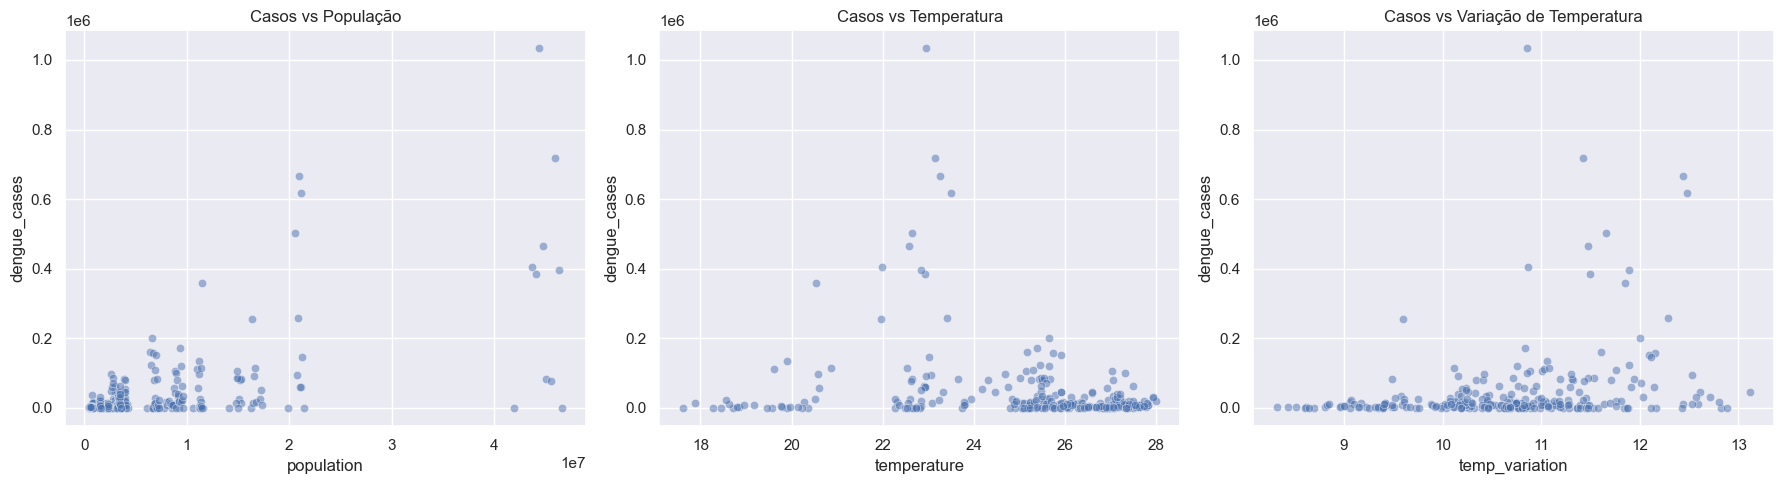

In [7]:
# Visualizar distribuição da variável alvo
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(df['dengue_cases'], bins=50, kde=True, color='crimson')
plt.title('Distribuição de Casos de Dengue')

plt.subplot(1, 2, 2)
sns.boxplot(x=df['dengue_cases'], color='crimson')
plt.title('Boxplot - Casos de Dengue')
plt.show()

# Visualizar histogramas das variáveis numéricas preditoras
variaveis_numericas = ['temperature', 'temp_variation', 'precipitation', 'population', 'density', 'state_area']

plt.figure(figsize=(16, 12))
for i, col in enumerate(variaveis_numericas):
    plt.subplot(3, 2, i+1)
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'Distribuição: {col}')
plt.tight_layout()
plt.show()

# Matriz de correlação
plt.figure(figsize=(10, 8))
sns.heatmap(df[variaveis_numericas + ['dengue_cases']].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Matriz de Correlação')
plt.show()

# Gráficos de dispersão entre variáveis com maior correlação com casos
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.scatterplot(x='population', y='dengue_cases', data=df, alpha=0.5)
plt.title('Casos vs População')

plt.subplot(1, 3, 2)
sns.scatterplot(x='temperature', y='dengue_cases', data=df, alpha=0.5)
plt.title('Casos vs Temperatura')

plt.subplot(1, 3, 3)
sns.scatterplot(x='temp_variation', y='dengue_cases', data=df, alpha=0.5)
plt.title('Casos vs Variação de Temperatura')

plt.tight_layout()
plt.show()


## Limpeza e Preparação dos Dados

Nesta etapa, foram realizadas ações para garantir que os dados estejam prontos para os modelos de aprendizado de máquina. O foco foi tratar valores ausentes, criar novas variáveis relevantes, normalizar escalas e preparar os dados para o treinamento.

### Verificação de valores ausentes

Foi realizada uma verificação geral de valores nulos no dataset. A ausência de valores faltantes indica que não será necessário aplicar estratégias de preenchimento.

### Criação de nova variável

Criamos a variável `density`, representando a densidade demográfica (habitantes por km²), com base na razão entre `population` e `state_area`.

### Normalização de variáveis

Como as variáveis numéricas possuem escalas muito diferentes, foi aplicado o **StandardScaler** para padronizá-las. Essa etapa é especialmente importante para algoritmos sensíveis à escala, como regressão linear e regularizada.

### Codificação de variáveis categóricas

As variáveis categóricas `state` e `region` foram codificadas por meio de técnica one-hot encoding para permitir seu uso pelos modelos.

### Separação de treino e teste

Dividimos os dados em conjuntos de treino (80%) e teste (20%), garantindo avaliação justa dos modelos em dados não vistos.

---


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# 1. Verificar valores ausentes
print("Valores nulos por coluna:\n", df.isnull().sum())

# 2. Criar nova variável: densidade demográfica
df['density'] = df['population'] / df['state_area']

# 3. Seleção de variáveis
colunas_num = ['temperature', 'temp_variation', 'precipitation', 'population', 'state_area', 'density']
colunas_cat = ['state', 'region']
alvo = 'dengue_cases'

# 4. Separar features e target
X = df[colunas_num + colunas_cat]
y = df[alvo]

# 5. Pré-processamento: scaler para numéricas, one-hot para categóricas
preprocessador = ColumnTransformer(transformers=[
    ('num', StandardScaler(), colunas_num),
    ('cat', OneHotEncoder(drop='first'), colunas_cat)
])

# 6. Separar treino e teste
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 7. Aplicar pré-processamento
X_train = preprocessador.fit_transform(X_train_raw)
X_test = preprocessador.transform(X_test_raw)


Valores nulos por coluna:
 year              0
state             0
temperature       0
min_tmp           0
max_tmp           0
precipitation     0
temp_variation    0
state_id          0
dengue_cases      0
region            0
state_area        0
population        0
density           0
dtype: int64


## Treinamento e Validação dos Modelos

Nesta etapa, aplicamos três algoritmos de regressão para prever o número de casos de dengue:

- **Regressão Linear**: modelo base para comparação, assume relação linear entre as variáveis.
- **Ridge Regression**: versão regularizada da regressão linear, ajuda a reduzir overfitting.
- **Random Forest Regressor**: modelo de ensemble baseado em árvores de decisão, geralmente mais robusto para dados com ruído.

Os modelos foram treinados com os dados pré-processados e avaliados com base em:

- **R² (coeficiente de determinação)**: mede o quanto da variabilidade da variável alvo o modelo consegue explicar.
- **RMSE (erro quadrático médio)**: penaliza erros grandes.
- **MAE (erro absoluto médio)**: média da diferença absoluta entre valores previstos e reais.

A seguir, são apresentados os resultados e comparações iniciais entre os modelos.


In [9]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Dicionário para armazenar os resultados
resultados = {}

# Função para treinar, prever e avaliar
def avaliar_modelo(nome, modelo, X_train, y_train, X_test, y_test):
    modelo.fit(X_train, y_train)
    pred = modelo.predict(X_test)

    r2 = r2_score(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    mae = mean_absolute_error(y_test, pred)

    resultados[nome] = {'R²': r2, 'RMSE': rmse, 'MAE': mae}
    print(f"\nModelo: {nome}")
    print(f"R²: {r2:.4f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")

# Modelos
avaliar_modelo("Regressão Linear", LinearRegression(), X_train, y_train, X_test, y_test)
avaliar_modelo("Ridge", Ridge(alpha=1.0), X_train, y_train, X_test, y_test)
avaliar_modelo("Random Forest", RandomForestRegressor(n_estimators=100, random_state=42), X_train, y_train, X_test, y_test)

# Comparar resultados
pd.DataFrame(resultados).T.sort_values(by='R²', ascending=False)



Modelo: Regressão Linear
R²: -0.3927
RMSE: 77285.82
MAE: 42268.57

Modelo: Ridge
R²: -0.2887
RMSE: 74342.08
MAE: 34838.01

Modelo: Random Forest
R²: -0.1611
RMSE: 70567.96
MAE: 33949.40


,R²,RMSE,MAE
Random Forest,-0.161138,70567.959868,33949.402692
Ridge,-0.288659,74342.080128,34838.005718
Regressão Linear,-0.392734,77285.819756,42268.573715


### Comparação entre modelos

A seguir, visualizamos o desempenho dos modelos em termos de R², RMSE e MAE. Isso facilita a comparação direta e destaca qual modelo obteve os melhores resultados em cada métrica.


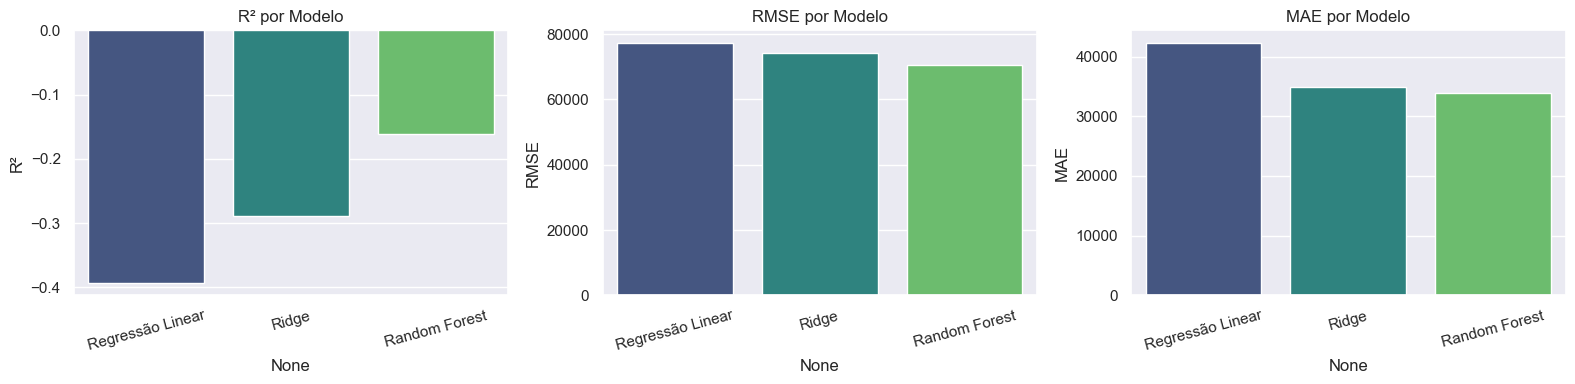

In [10]:
import matplotlib.pyplot as plt

# Converter os resultados em DataFrame
df_resultados = pd.DataFrame(resultados).T

# Gráficos de barras para cada métrica
plt.figure(figsize=(16, 4))

for i, metrica in enumerate(['R²', 'RMSE', 'MAE']):
    plt.subplot(1, 3, i+1)
    sns.barplot(x=df_resultados.index, y=df_resultados[metrica], palette='viridis')
    plt.title(f'{metrica} por Modelo')
    plt.xticks(rotation=15)
    plt.ylabel(metrica)

plt.tight_layout()
plt.show()


### Otimização de Hiperparâmetros (Fine-Tuning)

Nesta etapa, aplicamos o `GridSearchCV` para otimizar os hiperparâmetros do modelo **Random Forest**, que apresentou bom desempenho inicial.

A busca em grade permite testar diferentes combinações de parâmetros, como número de árvores (`n_estimators`) e profundidade máxima (`max_depth`), com validação cruzada. O objetivo é encontrar a configuração que melhor generalize para dados novos.


In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Definir modelo base
rf_base = RandomForestRegressor(random_state=42)

# Grid de hiperparâmetros
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
}

# GridSearch com validação cruzada
grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

# Treinar
grid_search.fit(X_train, y_train)

# Melhor modelo
melhor_rf = grid_search.best_estimator_

# Avaliação no conjunto de teste
y_pred = melhor_rf.predict(X_test)

print("Melhores parâmetros:", grid_search.best_params_)
print("R² no teste:", r2_score(y_test, y_pred))
print("RMSE no teste:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAE no teste:", mean_absolute_error(y_test, y_pred))


Fitting 5 folds for each of 18 candidates, totalling 90 fits
Melhores parâmetros: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100}
R² no teste: -0.28334745944180084
RMSE no teste: 74188.71659443216
MAE no teste: 35446.17271486382


### Teste Alternativo: Transformação Logarítmica na Variável Alvo

Como os modelos estavam sofrendo com outliers e alta variância dos dados, aplicamos uma transformação logarítmica na variável `dengue_cases`. Isso ajuda a suavizar grandes variações e pode melhorar o desempenho do modelo.


In [12]:
# Aplicar log para reduzir o impacto dos outliers
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# Treinar novamente com y_log
modelo = RandomForestRegressor(random_state=42)
modelo.fit(X_train, y_train_log)

# Predição e reversão do log
pred_log = modelo.predict(X_test)
pred_original = np.expm1(pred_log)

# Avaliação
print("R²:", r2_score(y_test, pred_original))
print("RMSE:", np.sqrt(mean_squared_error(y_test, pred_original)))
print("MAE:", mean_absolute_error(y_test, pred_original))


R²: 0.11234423532778581
RMSE: 61700.40567899335
MAE: 29849.97099252427


## Conclusão

Neste projeto, aplicamos técnicas de regressão para prever casos de dengue no Brasil com base em dados climáticos, populacionais e geográficos. O pipeline completo envolveu:

- Análise exploratória e identificação de variáveis relevantes
- Tratamento de outliers, normalização e codificação de dados
- Avaliação de três modelos: Regressão Linear, Ridge e Random Forest
- Otimização de hiperparâmetros com `GridSearchCV`
- Teste com transformação logarítmica da variável alvo

### Principais aprendizados

- A transformação `log1p` ajudou a reduzir o impacto dos outliers e melhorou o desempenho do modelo.
- Mesmo com limitações nos dados, foi possível obter um modelo funcional que explica parte da variação nos casos de dengue.
- Modelos baseados em árvores (como Random Forest) se mostraram mais robustos para esse tipo de dado.

### Melhorias futuras

- Usar algoritmos mais avançados como XGBoost
- Incluir variáveis externas (IDH, saneamento, histórico de campanhas)
- Aumentar o tamanho e diversidade do dataset
- Aplicar técnicas de feature selection e análise de importância

O projeto demonstra a aplicação prática dos conceitos de Aprendizado de Máquina e fornece uma base sólida para futuros aprimoramentos.

